# Use spark for machine learning

 The source data which we use in this tutorial is publicly available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). This data consists of `48842` american residents and their annual income. 
 The goal of this tutorial is to train a model which can predict if a person's revenue range is `<=50K` or `>50k` a year.
 

Dataset feature description:

| name           | type    | description                                                                                                         |
|----------------|---------|---------------------------------------------------------------------------------------------------------------------|
| age            | double  | age of the resident                                                                                                 |
| workclass      | string  | Simplified employment status of an individual. 9 distinct values: State-gov, Private,Self-emp-not-inc               |
| fnlwgt:        | integer | Final weight of the row. Basically interpret as the number of people represented by this row. (Continous, positive) |
| education      | string  | The education level. Categorical column, 13 distinct values. (e.g. Bachelors, Some-college, 11th, HS-grad...)       |
| education-num: | double  | The education level. Categorical column, 13 distinct values.  (e.g. 7.0, 9.0, 13.0)                                 |
| marital-status | string  | Marital status of a person. Categorical column, 7 distinct values Divorced e.g. Never-married, Separated,...        |
| occupation     | string  | Rough category of the occupation. (categorical, 15 distinct values) Tech-support, Craft-repair, Sales, ...          |
| relationship   | string  | Relationship in terms of the family.  (categorical, 6 distinct values) Wife, Own-child, Husband, ...                |
| race           | string  | Race of the person. (categorical, 5 distinct values) White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black    |
| sex            | string  | gender at-birth (boolean) Female, Male                                                                              |
| capital-gain   | double  | Dollar gain of capital. (continuous)                                                                                |
| capital-loss   | double  | Dollar loss of capital. (continuous)                                                                                |
| hours-per-week | double  | Working hours per week.(continous positive integer)                                                                 |
| native-country | string  | Country at birth.  (categorical, 41 distinct values) United-States, Cambodia, England, Puerto-Rico, Canada, Germany |


Dataset label description:

| name           | type    | description                                                                 |
|----------------|---------|-----------------------------------------------------------------------------|
| income-bracket | boolean | Income range of the person. True if ≥ 50K, otherwise False (< 50K per year) |

In [1]:
from pyspark.sql.types import StructType, DoubleType, StructField, StringType
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import LogisticRegression


from pyspark.sql import DataFrame
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Initialize a Spark Session

In [2]:
# here we use local mode
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("spark_ml") \
    .getOrCreate()

## Read the sample data

In [3]:
# data path
file_path = "../data/us_census_1994.csv"

# specify dataset schema
schema = StructType([
  StructField("age", DoubleType(), False),
  StructField("workclass", StringType(), False),
  StructField("fnlwgt", DoubleType(), False),
  StructField("education", StringType(), False),
  StructField("education_num", DoubleType(), False),
  StructField("marital_status", StringType(), False),
  StructField("occupation", StringType(), False),
  StructField("relationship", StringType(), False),
  StructField("race", StringType(), False),
  StructField("sex", StringType(), False),
  StructField("capital_gain", DoubleType(), False),
  StructField("capital_loss", DoubleType(), False),
  StructField("hours_per_week", DoubleType(), False),
  StructField("native_country", StringType(), False),
  StructField("income", StringType(), False)
])

In [4]:
# load dataset
df_raw = spark.read.option("header", True).schema(schema).csv(file_path)

In [5]:
df_raw.show(5)

+----+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|  fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|39.0|       State-gov| 77516.0|Bachelors|         13.0|     Never-married|     Adm-clerical|Not-in-family|White|  Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0|Self-emp-not-inc| 83311.0|Bachelors|         13.0|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|         Private|215646.0|  HS-grad|          9.0|          Divorced|Handl

In [6]:
df_raw.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



## Preprocess

To use algorithms like `Logistic Regression`, you must first convert the categorical features into numeric variables. There are two ways to do this.

In this tutorial, we use `StringIndexer`, and `OneHotEncoder` to do the transformation.

> One-Hot Encoding: categories into binary vectors with at most one nonzero value (eg: (Blue: [1, 0]), (Green: [0, 1]), (Red: [0, 0])).

### Step1. encode all feature categorical columns with one-hot encoding

In [7]:
# define a suffix for the encoded column name to distinguish with the origin column name
suffix_col_name:str = "classVec"
# specify all categorical columns in the dataset
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

# specify all numerical columns in the dataset
num_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# spark allows us to add a list of stages into the preprocessing pipeline. 
stages = [] 

for cat_col in cat_cols:
    # create a StringIndexer for the feature categorical column
    feature_col_indexer = StringIndexer(inputCol=cat_col, outputCol=cat_col + "Index")
    # create a feature encoder
    feature_encoder = OneHotEncoder(inputCols=[feature_col_indexer.getOutputCol()], outputCols=[cat_col + suffix_col_name])
    # Here we just add all required stages into the pipeline. These stages are not run here, but will run all at once later on.
    stages += [feature_col_indexer, feature_encoder]

### Step2: Encode label column with string indexer

Because the label column is boolean type, no need to use one-hot encoder.

In [8]:
# create a label stringIndexer which converts label into label indices
label_col_indexer = StringIndexer(inputCol="income", outputCol="label")
stages += [label_col_indexer]

### Step3: Transform numeric feature columns into a vector column

Now, all feature columns are in numeric. We need to transform them into a vector.

In [9]:
# We use `VectorAssembler` to transform all features columns into a vector column
feature_vec_col_name = "features"
assemblerInputs = [c + suffix_col_name for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol=feature_vec_col_name)
stages += [assembler]

### Step 4: Build a pipeline with all the above stages

We have all the stages for pre-processing the data. Now we need to build a pipeline and transform the raw data

In [10]:
prepro_pipeline = Pipeline().setStages(stages)
prepro_pipeline_model = prepro_pipeline.fit(df_raw)
transformed_df = prepro_pipeline_model.transform(df_raw)

In [11]:
transformed_df.show(5)

+----+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+--------------+-----------------+--------------+-----------------+-------------------+----------------------+---------------+------------------+-----------------+--------------------+---------+-------------+--------+-------------+-------------------+----------------------+-----+--------------------+
| age|       workclass|  fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|workclassIndex|workclassclassVec|educationIndex|educationclassVec|marital_statusIndex|marital_statusclassVec|occupationIndex|occupationclassVec|relationshipIndex|relationshipclassVec|raceIndex| raceclassVec|sexIndex|  sexclassVec|native_countryIndex|native_countryclassVec|label|            features|
+----+----------------+--------+

## Step5: Drop useless columns

All the intermediate indexing columns are useless for the model training, so we need to drop them to improve model training performance.

In the `clean_df`, we can notice the `label column` has two distinct values:
- 0: <=50k
- 1: >50k

and the `features column` is the vector which contains all information of the raw features

In [12]:
# Keep relevant columns
origin_feature_cols = df_raw.columns
required_cols = ["label", "features"] + origin_feature_cols
clean_df = transformed_df.select(required_cols)
clean_df.show(10)

+-----+--------------------+----+----------------+--------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|label|            features| age|       workclass|  fnlwgt|education|education_num|      marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+----+----------------+--------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|  0.0|(100,[4,10,24,32,...|39.0|       State-gov| 77516.0|Bachelors|         13.0|       Never-married|     Adm-clerical|Not-in-family|White|  Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|  0.0|(100,[1,10,23,31,...|50.0|Self-emp-not-inc| 83311.0|Bachelors|         13.0|  Married-civ-spouse|  Exec-managerial|      Husband|White|  Male

### Step6: Split dataset into training and test sets.

In [13]:
# set seed for reproducibility
training_df, test_df = clean_df.randomSplit([0.8, 0.2], seed=100)
print(training_df.count())
print(test_df.count())

26082
6479


## Train a logistic regression model





In [14]:
label_col_name = "label"

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol=label_col_name, featuresCol=feature_vec_col_name, maxIter=10)


### Check the hyperparameters of the model

In the above example, we only defined three hyperparameters. For other hyperparameters, we just use the default value. Below shows the complete list of configurable hyperparameters of the regression model. 

In [15]:
print("hyperparameter of the logic regression model:")
print(lr.explainParams())

hyperparameter of the logic regression model:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fit

### Train the model with Training Data

In [16]:
lr_model = lr.fit(training_df)

## Make predictions on test data

In [17]:
# LogisticRegression.transform() will only use the 'features' column.
predictions = lr_model.transform(test_df)

In [18]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well
selected_col_df = predictions.select("label", "prediction", "probability", "age", "occupation")
selected_col_df.show(5)

+-----+----------+--------------------+----+--------------+
|label|prediction|         probability| age|    occupation|
+-----+----------+--------------------+----+--------------+
|  0.0|       1.0|[0.17900869351550...|36.0|Prof-specialty|
|  0.0|       0.0|[0.71092798912257...|32.0|Prof-specialty|
|  0.0|       0.0|[0.68427292578580...|39.0|Prof-specialty|
|  0.0|       0.0|[0.60580304901341...|51.0|Prof-specialty|
|  0.0|       0.0|[0.60288965386941...|60.0|Prof-specialty|
+-----+----------+--------------------+----+--------------+
only showing top 5 rows



## Evaluate the model

There are many ways to evaluate the models. In this tutorial, we use the below stats:
- Confusion Matrix
- ROC Curve + AUC 

In [30]:
def show_cm(in_model: LogisticRegression, input_df: DataFrame):
    """
    This functions shows a confusion matrix plot of the given classification model.
    :param in_model: Input classification model
    :param input_df: Input dataset
    :return: 
    """
    prediction_df = in_model.transform(input_df) 
    # Get predictions and labels
    preds_pd = prediction_df.select("label", "prediction").toPandas()
    
    # Create confusion matrix
    cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])
    
    # Optional: create labels if you know them
    labels = ["Negative", "Positive"]  # or [0, 1] if you're working with numeric classes
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [31]:
def show_roc(in_model: LogisticRegression):
    """
    This functions shows a roc plot of the given classification model.
    :param in_model: Input classification model
    :return: None
    """
    model_summary = in_model.summary
    roc_df = model_summary.roc.toPandas()
    auc = model_summary.areaUnderROC
    
    # Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(roc_df['FPR'], roc_df['TPR'], label=f"ROC Curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [32]:
# create a binary classification evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [33]:
# Calculate the accuracy
evaluator_metric_name = "accuracy"
evaluator_metric_value = evaluator.setMetricName(evaluator_metric_name).evaluate(predictions)

print(f"The model {evaluator_metric_name}: {evaluator_metric_value:.5f}")

The model accuracy: 0.84550


In [34]:
# Calculate the precision
evaluator_metric_name = "weightedPrecision"
evaluator_metric_value = evaluator.setMetricName(evaluator_metric_name).evaluate(predictions)

print(f"The model {evaluator_metric_name}: {evaluator_metric_value:.5f}")

The model weightedPrecision: 0.83808


In [35]:
# Calculate the precision
evaluator_metric_name = "weightedRecall"
evaluator_metric_value = evaluator.setMetricName(evaluator_metric_name).evaluate(predictions)

print(f"The model {evaluator_metric_name}: {evaluator_metric_value:.5f}")

The model weightedRecall: 0.84550


In [36]:
# Calculate the accuracy
evaluator_metric_name = "f1"
evaluator_metric_value = evaluator.setMetricName(evaluator_metric_name).evaluate(predictions)

print(f"The model {evaluator_metric_name} score: {evaluator_metric_value:.5f}")

The model f1 score: 0.83907


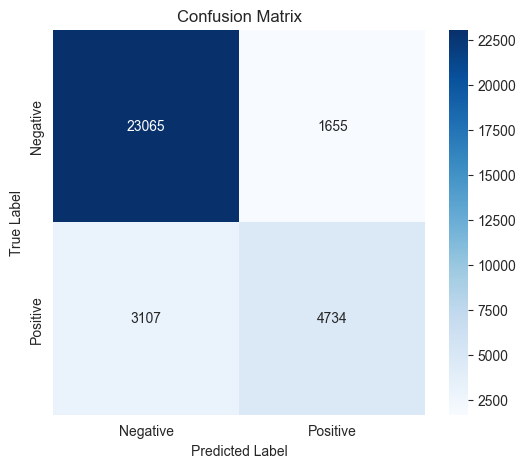

In [37]:
show_cm(lr_model, clean_df)

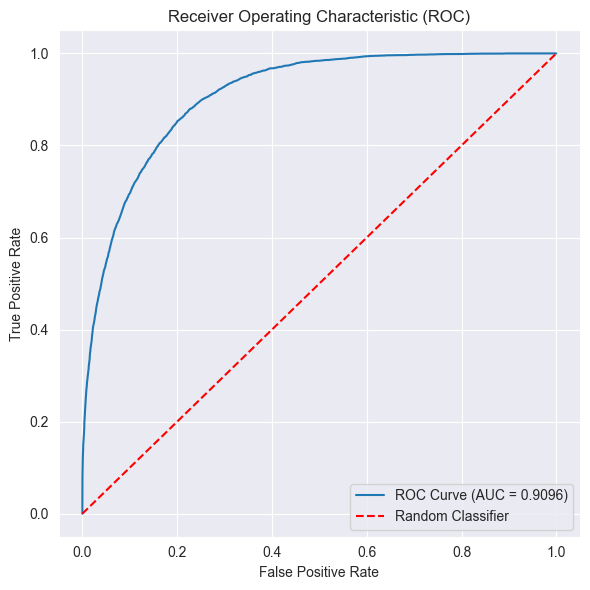

In [38]:
# ROC of the model
show_roc(lr_model)

In [ ]:
spark.stop()